# AnyoneAI - Sprint Project 04
> Vehicle Classification

You've been learning a lot about Deep Learning Algorithms, now we you're gonna be asked to put it all together. 


In [1]:
import sys

IN_COLAB = "google.colab" in sys.modules
IN_COLAB

True

In [2]:
if IN_COLAB:
    from google.colab import drive

    drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
if IN_COLAB:
    # Put here the full path to the folder having your Sprint project code
    # e.g. "/content/drive/MyDrive/assignment"
    ROOT_DIR = "/content/drive/MyDrive/assignment"
    %cd $ROOT_DIR

/content/drive/MyDrive/assignment


## Install dependencies (Only for Colab)

In [5]:
if IN_COLAB:
    # This will make sure you have installed all the proper dependencies
    # Instal dependencies
    !pip install -r requirements.txt
    # We can access to GPUs in Colab, so install GPU version of tensorflow
    !pip install tensorflow-gpu==2.8.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.4/103.4 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.0/297.0 kB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.2/121.2 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 49.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 104.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 73.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

## 1. Introduction

This is a Multi-class Classification task: we want to predict, given a picture of a vehicle, which of the possible 25 classes is the correct vehicle make-model.

The dataset is composed of JPG images, already stored in folders containing the label (vehicle make-model), separated in train and test sets.


In [6]:
import os

from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from src import data_utils, models, config

### Getting the data

To access the data for this project, you only need to execute the code below. This will download a zip file `cars_25_dataset.zip` containing inside:

- `car_ims_dataset`: Folder whit train and test images, already classified in sub-folders with the corresponding vehicle label.

- `train_dataset_annos.csv` and `test_dataset_annos.csv`: Train and test images annotations provided in CSV file format. You will not need these files unless you want to solve the optional exercises.


1.1. Download the training and test datasets.

In [7]:
if IN_COLAB:
    config.DATASET_ROOT_PATH = "/content/dataset/"

data_utils.download_datasets(config.DATASET_ROOT_PATH)

Downloading...
From: https://drive.google.com/uc?id=1ueaI8NJLS73Eq8Kx9ctdy5hK3vD53_Jb&confirm=t
To: /content/dataset/cars_25_dataset.zip
100%|██████████| 116M/116M [00:00<00:00, 164MB/s]


1.2. Setup some variables you will use during training the model.

The default values used here should work fine for you.

In [8]:
# Dataset folder
DATASET_FOLDER = os.path.join(config.DATASET_ROOT_PATH, config.DATASET_FILENAME)
DATASET_FOLDER = os.path.join(config.DATASET_ROOT_PATH, "eu-car-dataset_subset")

img_height = 224
img_width = 224
batch_size = 32

1.3. Load the training and testing images as a Tensorflow dataset (`tf.data.Dataset`).

Note that it's not a good idea to load all the images into memory because they may need more RAM than the one installed in the system. This is why we create generators using the `image_dataset_from_directory()` function, which loads the images only when they are needed and then releases the memory for loading another batch of new images from the disk.


**Don't change anything in this cell, just make it run correctly**

In [9]:
# Load train and test datasets
train_ds = keras.preprocessing.image_dataset_from_directory(
    directory=os.path.join(DATASET_FOLDER, "train"),
    labels="inferred",
    label_mode="categorical",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

test_ds = keras.preprocessing.image_dataset_from_directory(
    directory=os.path.join(DATASET_FOLDER, "test"),
    labels="inferred",
    label_mode="categorical",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 7509 files belonging to 25 classes.
Found 1875 files belonging to 25 classes.


**Checkpoint:** The cell above should output the following message:

```code
Found 7509 files belonging to 25 classes.
Found 1875 files belonging to 25 classes.
```

## 2. Basic EDA

Let's load and display some pictures with their labels.


2.1. Take the class names automatically inferred from the data generator and assign to `class_names` variable. We will use this to do some EDA and also to define the output units in the classification layer of our model.


**Don't change anything in this cell, just make it run correctly**

In [10]:
class_names = train_ds.class_names
print(class_names)

assert len(class_names) == 25

['abarth_595-turismo', 'abarth_grande-punto', 'bmw_z4', 'citroen_c-crosser', 'citroen_ds4', 'citroen_nemo', 'dacia_lodgy', 'ford_f-150', 'hyundai_h-350', 'hyundai_i30', 'land-rover_range-rover-velar', 'mercedes-benz_180', 'mercedes-benz_a-180', 'mercedes-benz_b-220', 'mercedes-benz_cla-220', 'mercedes-benz_cls-320', 'mercedes-benz_slk-350', 'mini_cooper-sd', 'nissan_nv400', 'nissan_primastar', 'peugeot_108', 'porsche_991', 'suzuki_ignis', 'volkswagen_fox', 'volkswagen_up!']


2.2. Let's show some pictures!

You can re-run the following cell as many times as you want and it will always show a new set of images and labels.

**Don't change anything in this cell, just make it run correctly**

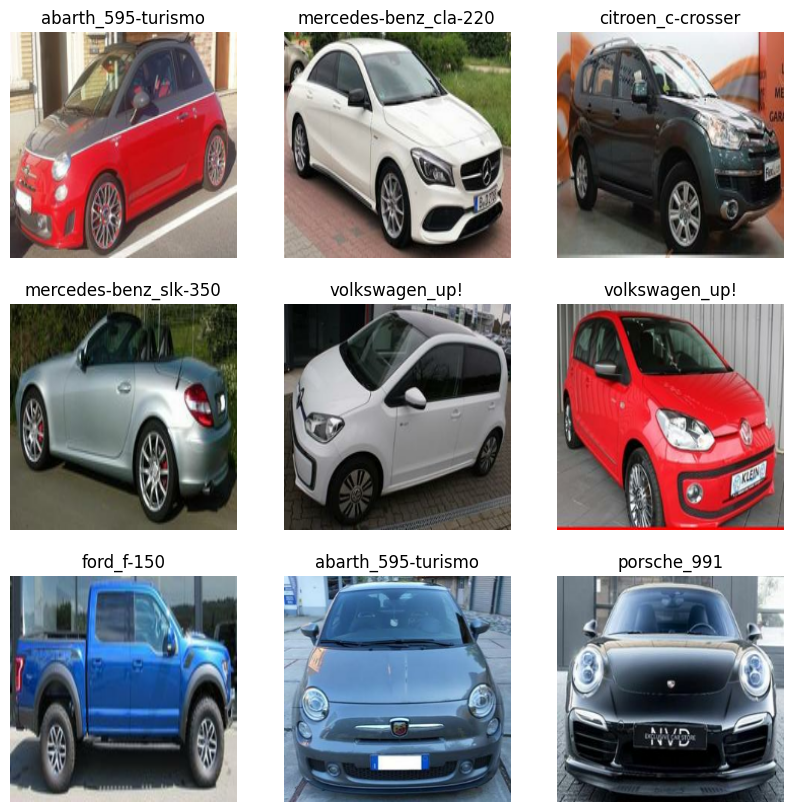

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

**Don't change anything in this cell, just make it run correctly**

In [11]:
# Configure data loader for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
# Define a function to plot the training and validation Acc and Loss
def plot_history(history):
  # Plot training & validation accuracy values
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

## 3. Multi-layer Perceptron

*Now it's time to train our first Neural Network model. For simplicity, we are going to try using an MLP model.*

*A Multi-layer Perceptron (MLP) is a simple neural network consisting of multiple layers of nodes connected by weighted edges. The input and output layers have one node per feature, and one node per target class respectively, while the intermediate layers have an arbitrary number of nodes. MLPs are known to work well for simple classification tasks, but they might not be suitable for image classification, where the input data has a high dimensionality and there are correlations between adjacent pixels.*

---

Executing the following cell will create a model using the `create_mlp_model()` functions you created and then run the training pipeline for it.

Feel free to change the code below to include any other optimization algorithm or change the default optimizer parameters like the `learning rate`.

It's also a good idea to change and experiment with different parameters for the `fit()` function. Try with more epochs and also adding [callbacks](https://keras.io/api/callbacks/) for saving the best weights (`ModelCheckpoint`), storing training logs (`TensorBoard` or `CSVLogger`), changing learning rate during training depending on the improvements in the loss function (`ReduceLROnPlateau`), etc.

**Important note:** Don't modify the model layers in the `create_mlp_model()` with different parameters to what we asked you to do in the function or you will break the project unit tests. If you want to experiment further with other model settings, feel free to create your own model in a separate function.


# Using callbacks to enhance the learning process

In [14]:
# Calbacks
# We will use early stopping to avoid overfitting,
# and ReduceLROnPlateau to reduce the learning rate if the accuracy does not improve.
callbacks=[
        keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            min_delta=0.001,
            patience=10,
            verbose=1,
            mode='auto',
            restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_accuracy",
            factor=0.1,
            patience=5,
            verbose=0,
            mode="auto",
            min_delta=0.001,
            cooldown=0,
            min_lr=0,
            )]




In [ ]:
mlp_model = models.create_mlp_model(
    input_shape=(img_height, img_width, 3), num_classes=len(class_names)
)

# Compile the model
mlp_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=5e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

history = mlp_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=100,
    callbacks= callbacks,
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 dense (Dense)               (None, 512)               77070848  
                                                                 
 dense_1 (Dense)             (None, 1024)              525312    
                                                                 
 dense_2 (Dense)             (None, 512)               524800    
                                                                 
 dense_3 (Dense)             (None, 25)                12825     
                                                                 
Total params: 78,133,785
Trainable params: 78,133,785
No

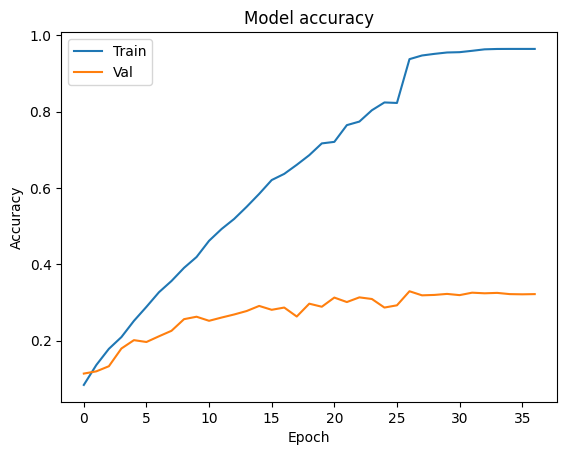

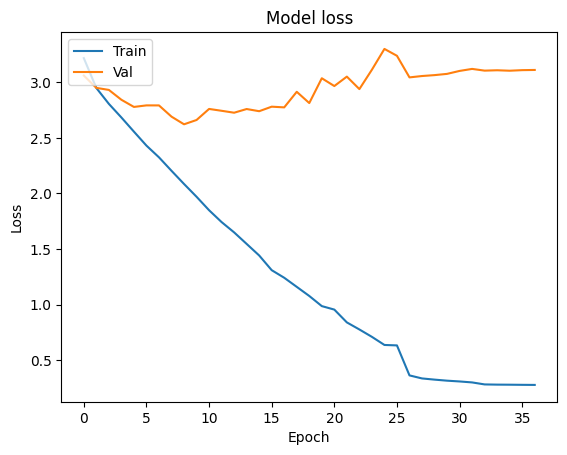

59/59 [==============================] - 1s 9ms/step - loss: 3.0435 - accuracy: 0.3296


In [ ]:
plot_history(history)

test_loss, test_accuracy = mlp_model.evaluate(test_ds)

At this point the model accuracy in the validation dataset should be around *0.3*.

What do you think about the relation between training accuracy and validation accuracy? Is the model overfitting or underfitting?

What changes can we apply to reach our goal of 0.8 (80%) accuracy on testing?

# Answers:
### Overfitting or underfitting
The first graph shows the Accuracy obtained in each epoch for both training and validation data. The second graph shows the evolution in each epoch of the Loss for the two data sets.

If we look at the general behavior of these graphs, we see that they are characteristic when a model is overfitting. On the one hand the Accuracy of the training data increases with the epochs, until it reaches almost 97%, while the Accuracy of the validation data stops around 32% and from here it remains constant throughout the epochs. Loss from the validation data reaches its minimum after around 9 epochs and then starts to rise slowly, while Loss from the training data decreases until it reaches almost 0.27 where it remains.

### Goal of 0.8 (80%) accuracy on testing
The overfitting depends from my point of view on the fact that it is a model with more than 78 million parameters trained from scratch with a data set of only 7509 images. The model has a lot of parameters compared to the number of training data, so it is very easy to overfit by parsing the data from memory. 
However, in order to increase the accuracy in the validation data, it is not enough to increase the number of training cases, since the model uses as descriptors the image itself flattened to a vector, which implies the loss of spatial information. The best approach would be to use a Convolutional Neural Network. 

## 4. CNN: LeNet

*Multi-layer Perceptrons are known to work well for simple classification tasks, but they might not be suitable for image classification, where the input data has a high dimensionality and there are correlations between adjacent pixels.*

*If the previous model wasn't enough for the accuracy we aim to achieve, we can try a bigger one, a Convolutional Network! We are going to use the first develop CNN, the LeNet model.*

*LeNet is a type of Convolutional Neural Network (CNN) that was specifically designed for image classification. LeNet uses a set of convolutional layers to extract low-level features such as edges and corners, and then combines them into higher-level features through a series of pooling layers. Finally, a set of fully connected layers is used to classify the images. LeNet has shown to be very effective in image classification tasks, especially in cases where the input images are small and the features are not too complex.*

---

Executing the following cell will create a model using the `create_lenet_model()` function you created and then run the training pipeline for it.

Feel free to change the code below to include any other optimization algorithm or change the default optimizer parameters like the `learning rate`.

It's also a good idea to change and experiment with different parameters for the `fit()` function. Try with more epochs and also adding [callbacks](https://keras.io/api/callbacks/) for saving the best weights (`ModelCheckpoint`), storing training logs (`TensorBoard` or `CSVLogger`), changing learning rate during training depending on the improvements in the loss function (`ReduceLROnPlateau`), etc.

**Important note:** Don't modify the model layers in the `create_lenet_model()` with different parameters to what we asked you to do in the function or you will break the project unit tests. If you want to experiment further with other model settings, feel free to create your own model in a separate function.


In [ ]:
lenet_model = models.create_lenet_model(
    input_shape=(img_height, img_width, 3), num_classes=len(class_names)
)

# Compile the model
lenet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=6e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

history_lenet=lenet_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=50,
    callbacks= callbacks,
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 average_pooling2d_4 (Averag  (None, 111, 111, 6)      0         
 ePooling2D)                                                     
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 average_pooling2d_5 (Averag  (None, 54, 54, 16)       0         
 ePooling2D)                                                     
                                                                 
 flatten_2 (Flatten)         (None, 46656)            

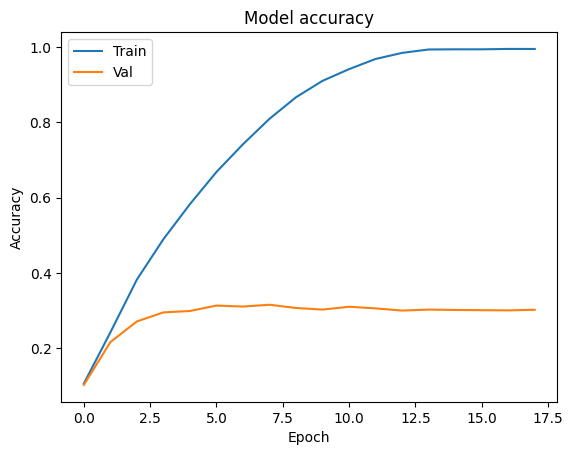

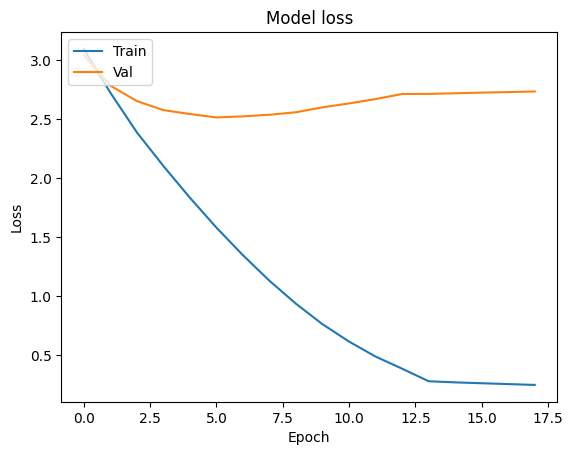

59/59 [==============================] - 1s 12ms/step - loss: 2.5372 - accuracy: 0.3157


In [ ]:
plot_history(history_lenet)

test_loss, test_accuracy = lenet_model.evaluate(test_ds)

At this point the model accuracy in the validation dataset should be around *0.3*.

What do you think about the relation between training accuracy and validation accuracy? Is the model overfitting or underfitting?

What changes can we apply to reach our goal of 0.8 (80%) accuracy on testing?

# Answers:
### Overfitting or underfitting.
These graphs look similar to the first one. 

If we look at the overall behavior, we also see that there is overfitting. On the one hand, the accuracy of the training data increases with epochs, reaching almost 100%, while that of the validation data stops at around 30%, and from here it remains constant across epochs. The Loss of the validation data reaches its minimum after about 9 epochs and then starts to slowly increase, while the Loss of the training data decreases until it reaches almost 0.25 where it remains.

### Target of 0.8 (80%) test accuracy.
Like the MLP model, Lenet has many parameters compared to the number of training data, so it is very easy to overfit and memorize the entire training data set. 

However, Lenet is a CNN, so it is able to capture better features than the MLP model presented above. To avoid overfitting and increase accuracy in the validation dataset, we can apply some regularization techniques such as L1 and L2, Dropout, or data augmentation. But in addition, we should increase the number of pictures in the training dataset. However, if we cannot obtain more images for training, a possible solution could be to obtain a pre-trained model such as Resnet50 or VGG16 and use transfer learning. These models are usually trained with large datasets like Imagenet, so we can use them as a feature extractor and train only the last fully connected layers adapted to our problem.  

## 5. CNN: Transfer learning from ResNet50

*Maybe the LeNet is still no the best choice for our task. Actually, most of the time, when solving image classification problems, the best results are achieved using pre-built CNN architecture pre-trained on imagenet dataset. This process is commonly known as **transfer learning** or **fine-tuning**.*

*ResNet50, is a much deeper CNN that was developed to tackle the problem of vanishing gradients in deep neural networks. ResNet50 is made up of many layers that are organized into blocks, each of which has a set of convolutional layers followed by shortcut connections that allow for the easy flow of information between layers. These shortcut connections help to prevent vanishing gradients and allow the network to learn very deep representations of the input images. This makes ResNet50 ideal for image classification tasks where the input images are complex and large.*

*Therefore, it would be better to use ResNet50 finetuning for image classification tasks, especially if the input images are complex and large, as it has been optimized for this specific task and has shown to be very effective in achieving state-of-the-art results. Additionally, using ResNet50 finetuning means that the model can take advantage of the pre-trained weights on a large dataset, which can lead to faster convergence and better performance on smaller datasets.*

---

Executing the following cell will create a model using the `create_resnet50_model()` function you created and then run the training pipeline for it.

Feel free to change the code below to include any other optimization algorithm or change the default optimizer parameters like the `learning rate`.

It's also a good idea to change and experiment with different parameters for the `fit()` function. Try with more epochs and also adding [callbacks](https://keras.io/api/callbacks/) for saving the best weights (`ModelCheckpoint`), storing training logs (`TensorBoard` or `CSVLogger`), changing learning rate during training depending on the improvements in the loss function (`ReduceLROnPlateau`), etc.

**Important note:** Don't modify the model layers in the `create_resnet50_model()` with different parameters to what we asked you to do in the function or you will break the project unit tests. If you want to experiment further with other model settings, feel free to create your own model in a separate function.


In [ ]:
resnet50_model = models.create_resnet50_model(
    input_shape=(img_height, img_width, 3), num_classes=len(class_names)
)

# Compile the model
resnet50_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=5e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

history_resnet50 = resnet50_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=50,
    callbacks=callbacks,
)

94781440/94765736 [==============================] - 5s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 100352)            0         
                                                                 
 dropout (Dropout)           (None, 100352)            0         
                                                                 
 dense_6 (Dense)             (None, 25)                2508825   
                                                                 
Total params: 26,096,537
Trainable params: 2,508,825
Non-trainable params: 23,587,712
_________________________________________________________________
None
Epoch 1/50
235/235 [==============================] - 37s 137ms/step - loss: 3.3042 - accuracy: 

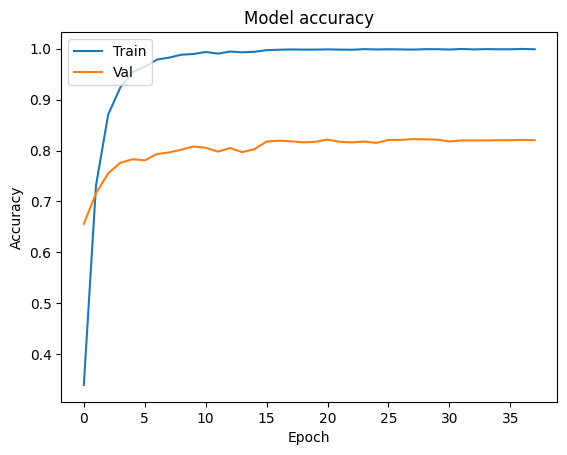

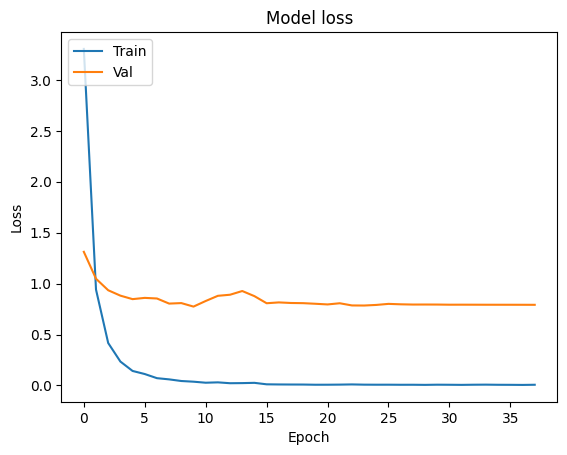

59/59 [==============================] - 6s 102ms/step - loss: 0.7942 - accuracy: 0.8224


In [ ]:
plot_history(history_resnet50)
test_loss, test_accuracy = resnet50_model.evaluate(test_ds)

At this point the model accuracy in the validation dataset should be around *0.7*.

What do you think about the relation between training accuracy and validation accuracy? Is the model overfitting or underfitting?

What changes can we apply to reach our goal of 0.8 (80%) accuracy on testing?

# Answers:
### Overfitting or underfitting.
At this point, we have graphs similar to the first ones, with the difference that we have obtained an accuracy of more than 80% in the validation.  There is overfitting, of course, but we only have a difference between training and validation performance of 20%, in contrast to 70% for the first models.  

### Target of 0.8 (80%) test accuracy.. 
Having used a very deep pre-trained model, and trained only the output adapted to our problem, we have achieved clearly superior results compared to previous models trained from scratch. 
Something we could do to eliminate overfitting is to apply some kind of regularization beyond the Dropout layer that we placed before the dense output network. It may also be necessary to achieve better Accuracy, to have a more complex output-dense network, and to apply fine-tuning to the entire model, including the Resnet50 itself.

## 6. Analyze model results

Choose your best model and report some metrics on the results you obtained.

You can plot a confussion matrix or use [Scikit-learn classification report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html).


In [ ]:
# Predict over test

# Import clasification report function
from sklearn.metrics import classification_report

# Generate predictions for the test dataset
y_test_pred = resnet50_model.predict(test_ds)

# Convert the predictions and ground truth labels to arrays or lists
y_pred_classes = np.argmax(y_test_pred , axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_true_classes = np.argmax(y_true, axis=1)

# Use classification_report to generate a report of the precision, recall, F1-score, and support for each class
print(classification_report(y_true = y_true_classes, 
                            y_pred = y_pred_classes, 
                            target_names = class_names)
)

                              precision    recall  f1-score   support

          abarth_595-turismo       0.83      0.96      0.89        80
         abarth_grande-punto       0.97      0.74      0.84        78
                      bmw_z4       0.80      0.90      0.85        80
           citroen_c-crosser       0.88      0.90      0.89        77
                 citroen_ds4       0.82      0.85      0.83        80
                citroen_nemo       0.90      0.97      0.93        80
                 dacia_lodgy       0.92      0.97      0.95        80
                  ford_f-150       0.88      0.95      0.92        80
               hyundai_h-350       0.77      0.78      0.77        46
                 hyundai_i30       0.77      0.78      0.77        80
land-rover_range-rover-velar       0.95      0.91      0.93        43
           mercedes-benz_180       0.49      0.44      0.46        80
         mercedes-benz_a-180       0.59      0.66      0.62        80
         mercedes-b

## 7. Optional. Make your own model

The models we've trained before are just a limited set over the universe of stuff you can use. 

You still have a lot of things to experiment with to increase accuracy, some ideas are:

1. Use any other CNN architecture you think may perform better than ResNet50.
2. Try adding data augmentation or any other regularization algorithms.
3. Train using more epochs, a different optimization algorithm, etc.
4. Check [KerasTuner](https://keras.io/api/keras_tuner/) documentation about how to efficiently test a lot of different architectures and parameters.

## Optional solution
In order to increase the Acc and decrease the overfitting, it was decided to improve the experimentation performed with ResNet50. Unlike the previous procedure, Data augmentation layers were added, so that the model could see a wider variety of data during training. In addition, the entire model, including the ResNet50, was fine-tuned to better fit the problem at hand. Finally, a four-layer Dense network was placed at the output. 

In [15]:
# Load ResNet50 pretrained with ImageNet dataset. 
# We have set include_top=false, so that we can place our own Dense network at the output. 
resnet = keras.applications.ResNet50(
    weights='imagenet', 
    include_top=False, 
    input_shape=(img_height, img_width, 3), 
    )

# Define the model
model = keras.models.Sequential()

# add data augmentation layers to the model
model.add(keras.layers.InputLayer(input_shape=(img_height, img_width, 3)))
model.add(keras.layers.RandomFlip(mode='horizontal'))
model.add(keras.layers.RandomRotation(factor=0.1))
model.add(keras.layers.RandomZoom(height_factor=0.1, width_factor=0.1))
model.add(keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1))

# add the Resnet50 model
model.add(resnet)

# Add a flatten layer to convert the output of the model to a 1D array
model.add(keras.layers.Flatten())

# Add Dense layers at the end
model.add(keras.layers.Dense(512, activation = 'relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(256, activation = 'relu'))
model.add(keras.layers.Dense(128, activation = 'relu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(len(class_names), activation="softmax"))

# Print a summary of the model architecture
print(model.summary())

# Compile the model with a low learning rate 
opt = keras.optimizers.Adam(learning_rate=6e-5) 
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

history_my_model = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=35,
    callbacks=callbacks,
)

94781440/94765736 [==============================] - 5s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 224, 224, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 224, 224, 3)       0         
                                                                 
 random_translation (RandomT  (None, 224, 224, 3)      0         
 ranslation)                                                     
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                         

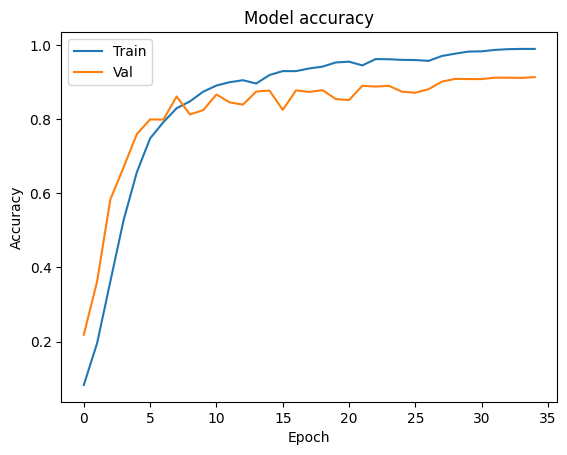

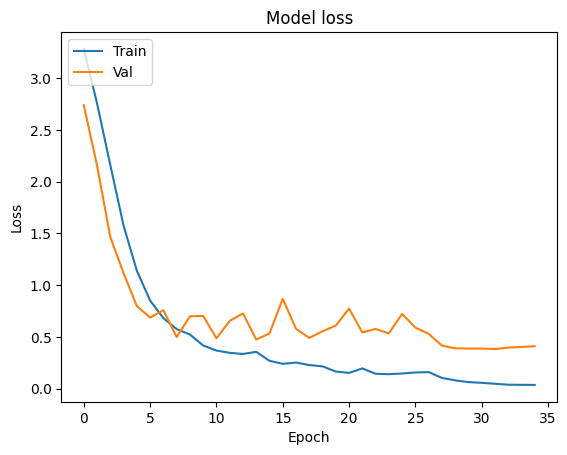

59/59 [==============================] - 6s 95ms/step - loss: 0.4101 - accuracy: 0.9136


In [16]:
plot_history(history_my_model)
test_loss, test_accuracy = model.evaluate(test_ds)

In [17]:
from sklearn.metrics import classification_report

In [18]:
# Step 1: Generate predictions for the test dataset
y_test_pred = model.predict(test_ds)

# Step 2: Convert the predictions and ground truth labels to arrays or lists
y_pred_classes = np.argmax(y_test_pred , axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_true_classes = np.argmax(y_true, axis=1)

# Step 3: Use classification_report to generate a report of the precision, recall, F1-score, and support for each class
print(classification_report(y_true = y_true_classes, 
                            y_pred = y_pred_classes, 
                            target_names = class_names)
)

                              precision    recall  f1-score   support

          abarth_595-turismo       0.93      0.96      0.94        80
         abarth_grande-punto       0.97      0.87      0.92        78
                      bmw_z4       0.95      0.90      0.92        80
           citroen_c-crosser       0.99      0.94      0.96        77
                 citroen_ds4       0.91      0.99      0.95        80
                citroen_nemo       0.96      0.96      0.96        80
                 dacia_lodgy       1.00      0.99      0.99        80
                  ford_f-150       1.00      0.96      0.98        80
               hyundai_h-350       0.78      0.87      0.82        46
                 hyundai_i30       0.86      0.95      0.90        80
land-rover_range-rover-velar       0.91      1.00      0.96        43
           mercedes-benz_180       0.65      0.66      0.65        80
         mercedes-benz_a-180       0.77      0.79      0.78        80
         mercedes-b

# Archive the weights of the best model

In [19]:
model.save('/content/drive/MyDrive/assignment/my_best_model.h5')